In [1]:
import os
from tqdm.notebook import tqdm

import numpy as np
from scipy import fft
import matplotlib.pyplot as plt

import torchvision as tv
import torch

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score

from eigvec.circulant import compute_kappa

## Circulant Images

In [2]:
# Image files
base_dir = "../../convolutional_ar/datasets/kylberg_rot/"
f = os.listdir(base_dir)
f.sort()
f = [i for i in f if i.endswith('.png')]

# Randomly choose rotation angle
f_rand = []

n_imgs = 4480

i_start = 0
for i in range(n_imgs):
    inds = np.arange(i_start, i_start+12)
    
    np.random.seed(i)
    ind = np.random.choice(inds)
    
    f_rand.append(f[ind])
    i_start += 12

# Classes
classes = [i.split('-')[0].split('.')[0] for i in f]
classes = np.unique(classes)

y = np.arange(len(classes))

classes = {c:int(i) for c, i in zip(classes, y)}
n_classes = len(classes)

# Data and labels
X = torch.zeros(len(f_rand), 576, 576)
y = torch.zeros(len(f_rand))

for i in range(len(f_rand)):
    X[i] = tv.io.read_image(f"{base_dir}/{f_rand[i]}")[0]
    y[i] = classes[f_rand[i].split('-')[0].split('.')[0]]

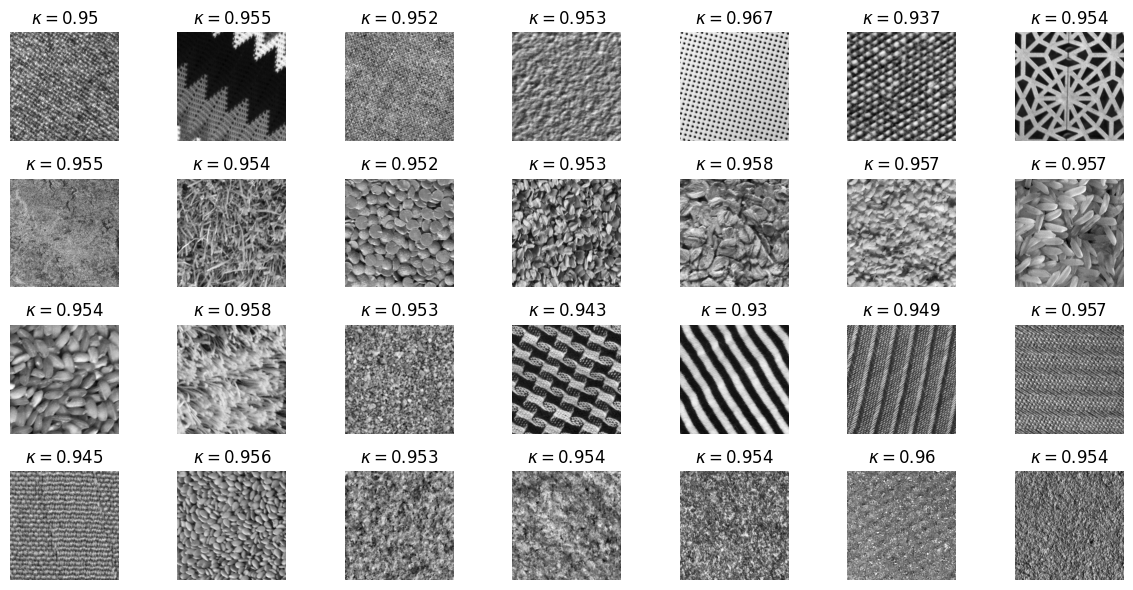

In [3]:
fig, axes = plt.subplots(nrows=4, ncols=7, figsize=(12, 6))
axes = axes.flatten()

for ind in range(28):
    
    _X = X[torch.where(y == ind)[0][0]].numpy()

    kappa = compute_kappa(_X)

    axes[ind].imshow(_X, cmap='gray')
    axes[ind].axis("off")

    axes[ind].set_title(r"$\kappa = $" + str(kappa.round(3)))

plt.tight_layout()

## Eigenvalues as Fourier Coefficients

Below is a 2d Welch's PSD. The PSD of sub-images are combined to get a smoother estimate.

In [4]:
n = len(X[0])

pad = 100
step = 50

vecs = np.fft.fft(np.eye(int(2*pad))) / np.sqrt(int(2*pad))
vecs = torch.from_numpy(vecs).cfloat()

powers = np.zeros((len(X), pad))

for ix in tqdm(range(len(X)), total=len(X)):
    
    _powers = torch.zeros(pad)
    
    ii = 0
    for i in range(pad, n-pad, step):
        for j in range(pad, n-pad, step):
            x = X[ix][i-pad:i+pad, j-pad:j+pad]
            _vals = torch.diag(torch.fft.fft2(x)/n)[:len(x)//2]
            _powers += torch.abs(_vals)**2
            ii += 1
            
    powers[ix] = _powers / ii

  0%|          | 0/4480 [00:00<?, ?it/s]

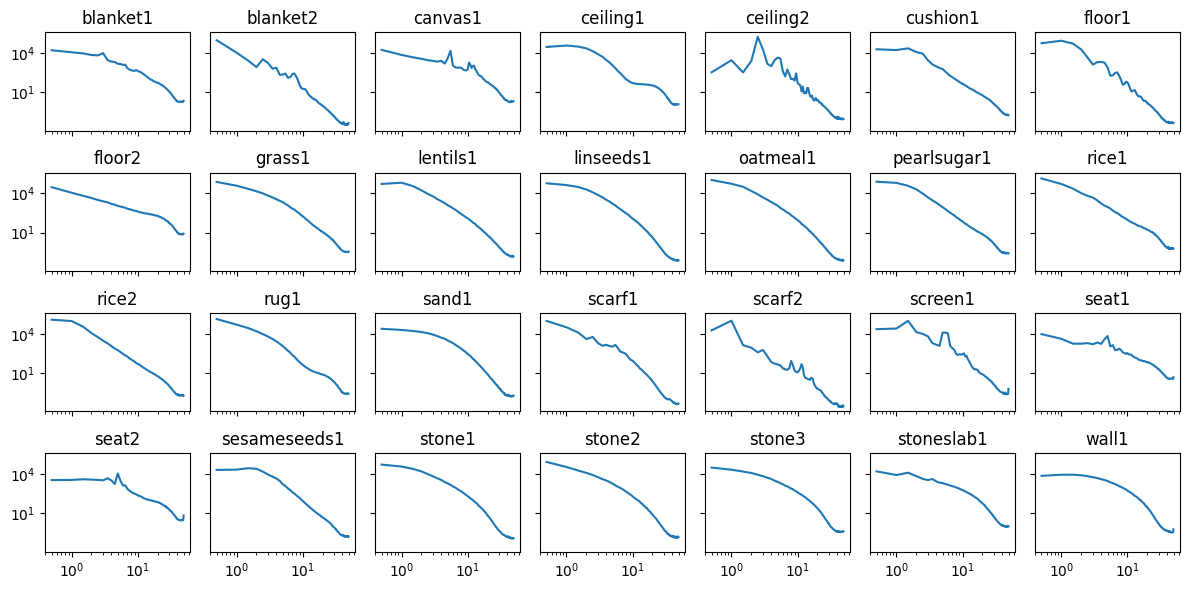

In [5]:
freqs = fft.fftfreq(int(2*pad), 1/100)[:100]

classes_inv = {v:k for k, v in classes.items()}

fig, axes = plt.subplots(nrows=4, ncols=7, figsize=(12, 6), sharex=True, sharey=True)
axes = axes.flatten()

for ind in range(28):
    p = powers[torch.where(y == ind)[0]].mean(axis=0)
    axes[ind].loglog(freqs[1:], p[1:])
    axes[ind].set_title(str(classes_inv[ind]))

plt.tight_layout()

In [6]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(np.log10(powers), y.numpy(), train_size=0.5)

# Normalize
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

# Fit SVM
svc = SVC(C=1e1)
svc.fit(X_train, y_train)

# Accuracy
print('Train Accuracy: ', (svc.predict(X_train) == y_train).sum() / len(y_train))
print('Test  Accuracy: ', (svc.predict(X_test) == y_test).sum() / len(y_test))

Train Accuracy:  0.9861607142857143
Test  Accuracy:  0.9084821428571429


## Dilation

Dilation of X is used to improve accuracy. This is done through ``image[::factor, ::factor]`` and stepping ``factor``. This is similar the same is dilating a convolutional kernel.

In [94]:
n = len(X[0])

pad = 50
step = 25

vecs = np.fft.fft(np.eye(int(2*pad))) / np.sqrt(int(2*pad))
vecs = torch.from_numpy(vecs).cfloat()

powers = []

for ix in tqdm(range(len(X)), total=len(X)):

    powers_i = []
    
    for factor in [1, 2, 3, 4, 5]:
        
        ii = 0
        for i in range(pad, n-pad, step):
            for j in range(pad, n-pad, step):
                
                x = X[ix][i-pad:i+pad, j-pad:j+pad]
                x = x[::factor, ::factor]

                _vals = torch.diag(torch.fft.fft2(x)/n)[:len(x)//2]
    
                if ii == 0:
                     _powers = torch.zeros(len(_vals))
                    
                _powers += torch.abs(_vals)**2
                ii += 1
                
        powers_i.append(_powers)
        
    powers.append(powers_i)

  0%|          | 0/4480 [00:00<?, ?it/s]

In [101]:
# Reshape powers
X_powers = [torch.concatenate(p) for p in powers]
X_powers = torch.row_stack(X_powers)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(np.log10(X_powers), y.numpy(), train_size=0.8)

# Normalize
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

# Fit SVM
svc = SVC(C=1e2)
svc.fit(X_train, y_train)

# Accuracy
print('Train Accuracy: ', (svc.predict(X_train) == y_train).sum() / len(y_train))
print('Test  Accuracy: ', (svc.predict(X_test) == y_test).sum() / len(y_test))

Train Accuracy:  0.9949776785714286
Test  Accuracy:  0.9419642857142857
